<a href="https://colab.research.google.com/github/Andreas-Lukito/Stock_Sentiment_Analysis/blob/dev%2Fandreas/notebooks/03_colab_word2vec-lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec + LSTM model

## Install Libraries

In [ ]:
! pip install contractions emoji gensim optuna torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.2 MB/s eta 0:00:00


## Import Libraries

In [ ]:
# Common Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from IPython.display import clear_output
import random
from copy import deepcopy
import time
import json

# Cleaner output
from tqdm import tqdm

# Deep Learning Libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch import inf

# Text Embedding Method
import gensim
from gensim.models import Word2Vec

# Data Preprocessing
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
## Download nltk dependencies
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

## Deep Learning Hyperparameter Tuning
import optuna
from optuna.exceptions import TrialPruned
from optuna.trial import TrialState

# Model metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/stock_news_sentiment_analysis"

# Add the path to the text preprocessor
sys.path.append(os.path.abspath(os.path.join(project_path, "lib")))

## Import preprocessor
from preprocessor import clean_text

# Project Seed for Reproducability
SEED = random.randint(0, 2**32 - 1)  # Random integer between 0 and 2^32-1
print(f"seed: {SEED}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Mounted at /content/drive
seed: 1388048498


## GPU Selection

In [ ]:
# Detect available device
if torch.cuda.is_available():
    # check if ROCm backend is active
    if torch.version.hip is not None:
        backend = "ROCm"
    else:
        backend = "CUDA"

    device = torch.device("cuda")
    print(f"PyTorch is using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Backend: {backend}")
else:
    device = torch.device("cpu")
    print("PyTorch is not using GPU — running on CPU")

PyTorch is using GPU: NVIDIA A100-SXM4-80GB
Backend: CUDA


## Import Data

In [ ]:
before_date = "2025-11"

# Data path
cleaned_data_path = os.path.join(project_path,f"news_cache/{before_date}/csv/")
clean_cached_file = os.path.join(cleaned_data_path, f"{before_date}_clean_news_data.csv")

# Import Data
news_data = pd.read_csv(filepath_or_buffer=clean_cached_file, sep=',')

In [ ]:
news_data.head(10)

,uuid,title,description,keywords,snippet,url,image_url,language,published_at,source,relevance_score,entities,similar,sentiment,text,length,clean_text
0,487e6a88-d3c2-4ae1-8dc2-26af6b31d688,2025: The Year Of Alphabet (GOOG),No stock has seen a bigger jump recently than ...,NaN,vzphotos/iStock Editorial via Getty Images\n\n...,https://seekingalpha.com/article/4848680-2025-...,https://static.seekingalpha.com/cdn/s3/uploads...,en,2025-11-30T05:30:00.000000Z,seekingalpha.com,NaN,"[{'symbol': 'GOOGL', 'name': 'Alphabet Inc.', ...",[],0.00000,vzphotos/iStock Editorial via Getty Images\n\n...,42,vzphotos istock editorial via getty images sin...
1,92b5c2bd-d324-4ae8-b115-2cfd95a8fa98,Why I'm Doubling Down On My Adobe Position (NA...,"Adobe's revenue is highly predictable, driven ...",NaN,To say that Adobe ( ADBE ) stock has not had a...,https://seekingalpha.com/article/4848762-why-i...,https://static.seekingalpha.com/cdn/s3/uploads...,en,2025-11-30T05:25:01.000000Z,seekingalpha.com,NaN,"[{'symbol': 'ADBE', 'name': 'Adobe Inc.', 'exc...",[],0.00000,Why I'm Doubling Down On My Adobe Position (NA...,1,doubling adobe position nasdaq adbe adobe reve...
2,9084e5f1-75f5-4f15-aa3d-0676073b4aaf,Global week ahead: The start of a Santa Rally ...,NaN,"STOXX 600, business news",And just like that... December is upon us. It'...,https://www.cnbc.com/2025/11/30/global-week-ah...,https://image.cnbcfm.com/api/v1/image/10823257...,en,2025-11-30T05:10:58.000000Z,cnbc.com,NaN,"[{'symbol': 'M', 'name': ""Macy's, Inc."", 'exch...",[],0.69080,And just like that... December is upon us. It'...,493,like december upon us volatile handover novemb...
3,7d36a275-f3a3-44ea-8cbc-caa0d67749c4,Global Risk Monitor: Week in Review – Nov 28,KEY ISSUES Silver surged 13% for the week and ...,NaN,KEY ISSUES\n\nSilver surged 13% for the week a...,https://global-macro-monitor.com/2025/11/29/gl...,https://global-macro-monitor.com/wp-content/up...,en,2025-11-30T05:07:50.000000Z,global-macro-monitor.com,NaN,"[{'symbol': 'NVDA', 'name': 'NVIDIA Corporatio...",[],-0.36120,KEY ISSUES\n\nSilver surged 13% for the week a...,729,key issues silver surged 13 week 90 year date ...
4,42ba634c-b7ce-491a-91c0-e2b1424af827,"Mcap boost: 7 of top-10 firms gain ₹96,201 cr;...",Market valuations of seven top firms rose by ₹...,NaN,The combined market valuation of seven of the ...,https://www.thehindubusinessline.com/markets/m...,https://bl-i.thgim.com/public/incoming/ji6cih/...,en,2025-11-30T05:04:20.000000Z,thehindubusinessline.com,NaN,"[{'symbol': 'SBKFF', 'name': 'State Bank of In...",[],0.00000,The combined market valuation of seven of the ...,254,combined market valuation seven top 10 valued ...
5,47000f09-22ab-4309-9411-c0c738327c25,QQQX: Tax-Efficient Dividends From The Nasdaq-...,Discover why Nuveen NASDAQ 100 Dynamic Overwri...,NaN,"With the rise of covered call ETFs, it can be ...",https://seekingalpha.com/article/4848757-qqqx-...,https://static.seekingalpha.com/cdn/s3/uploads...,en,2025-11-30T04:23:00.000000Z,seekingalpha.com,NaN,"[{'symbol': 'QQQX', 'name': 'Nuveen Nasdaq 100...",[],0.37150,QQQX: Tax-Efficient Dividends From The Nasdaq-...,1,qqqx tax efficient dividends nasdaq 100 nasdaq...
6,927ce408-c559-4f17-b673-37b0e9e301d7,Wall Street predicts rebound in Indian markets...,Wall Street giants anticipate a rebound for In...,"Indian markets rebound, Morgan Stanley India f...",Live Events\n\nBloomberg\n\nBloomberg\n\nRBI S...,https://economictimes.indiatimes.com/markets/s...,"https://img.etimg.com/thumb/msid-125668199,wid...",en,2025-11-30T04:14:43.000000Z,economictimes.indiatimes.com,NaN,"[{'symbol': 'C', 'name': 'Citigroup Inc.', 'ex...",[{'uuid': 'd359704e-cc4f-4e18-a564-f8e189eae75...,-0.63690,It seems like you're already an ETPrime member...,41,seems like already etprime member login using ...
7,8eaf98bd-e728-4d9b-8d4b-013a8c66a173,Dow Stock: Approaching A Bottom But Recovery W...,"Dow faces weak demand and excess capacity, but...",NaN,Shares of Dow have been a very poor performe

## Clean Data

### Check for Missing Values

In [ ]:
is_na = pd.DataFrame(news_data.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_data) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0            0.000000
title                         0            0.000000
description                 414            4.566009
keywords                   4774           52.652476
snippet                      37            0.408073
url                           0            0.000000
image_url                    36            0.397044
language                      0            0.000000
published_at                  0            0.000000
source                        0            0.000000
relevance_score            9067          100.000000
entities                      0            0.000000
similar                       0            0.000000
sentiment                     0            0.000000
text                          0            0.000000
length                        0            0.000000
clean_text                    0            0.000000


### Check for Duplicates

In [ ]:
news_data.duplicated().sum()

np.int64(0)

## Split the Data to Train, Test, and Validation

In [ ]:
test_size = 0.20
val_size = 0.10

# Splitting the data into train and temp (which will be further split into validation and test)
train_df, test_df = train_test_split(news_data, test_size=test_size, random_state=SEED)

# Splitting train into validation and test sets
train_df, val_df = train_test_split(train_df, test_size=val_size, random_state=SEED)

## Preprocessing

### Word Tokenization

the words in the sentence would be tokenized since gensim's fasttext model requires the sentence to be tokenized

In [ ]:
# tqdm for cleaner output
tqdm.pandas(desc="Preprocessing Train Data...", unit="news")
train_df["tokenized_text"] = train_df["clean_text"].progress_apply(
                                                    lambda x: clean_text(
                                                        text = x,
                                                        tokenize = True,
                                                        remove_stop_words = True,
                                                        stem_words = True,
                                                        remove_url = True,
                                                        remove_emojis = "keep"
                                                        )
                                                    )

tqdm.pandas(desc="Preprocessing Test Data...", unit="news")
test_df["tokenized_text"] = test_df["clean_text"].progress_apply(
                                                    lambda x: clean_text(
                                                        text = x,
                                                        tokenize = True,
                                                        remove_stop_words = True,
                                                        stem_words = True,
                                                        remove_url = True,
                                                        remove_emojis = "keep"
                                                        )
                                                    )

tqdm.pandas(desc="Preprocessing Validation Data...", unit="news")
val_df["tokenized_text"] = val_df["clean_text"].progress_apply(
                                                    lambda x: clean_text(
                                                        text = x,
                                                        tokenize = True,
                                                        remove_stop_words = True,
                                                        stem_words = True,
                                                        remove_url = True,
                                                        remove_emojis = "keep"
                                                        )
                                                    )

Preprocessing Validation Data...: 100%|██████████| 726/726 [00:03<00:00, 233.69news/s]


## Word Embedding

### Train Word2Vec Model

In [ ]:
# Train the word2vec model
w2v_model = Word2Vec(
    sentences=train_df["tokenized_text"].to_list(),
    vector_size=100,
    window=5, # Max distance from target word
    min_count=2,
    sg=1, # use skip gram (0 for CBOW)
    workers=-1 #all cores to train
)

### Apply Word2Vec to the Dataset

In [ ]:
# sentence vector function

def get_vectors(tokens: list[str]):
    return [w2v_model.wv.get_vector(word) for word in tokens if word in w2v_model.wv]

In [ ]:
# tqdm for cleaner output
tqdm.pandas(desc="Vectorizing Train Data...", unit="news")
train_df["vectorized_text"] = train_df["tokenized_text"].progress_apply(
                                                    lambda x: get_vectors(
                                                        tokens = x
                                                        )
                                                    )

tqdm.pandas(desc="Vectorizing Test Data...", unit="news")
test_df["vectorized_text"] = test_df["tokenized_text"].progress_apply(
                                                    lambda x: get_vectors(
                                                        tokens = x
                                                        )
                                                    )

tqdm.pandas(desc="Vectorizing Validation Data...", unit="news")
val_df["vectorized_text"] = val_df["tokenized_text"].progress_apply(
                                                    lambda x: get_vectors(
                                                        tokens = x
                                                        )
                                                    )

Vectorizing Validation Data...: 100%|██████████| 726/726 [00:00<00:00, 4316.90news/s]


## Split the X and Y values

In [ ]:
x_train = train_df["vectorized_text"]
x_test = test_df["vectorized_text"]
x_val = val_df["vectorized_text"]

y_train = train_df["sentiment"].to_numpy()
y_test = test_df["sentiment"].to_numpy()
y_val = val_df["sentiment"].to_numpy()

## Apply Padding

In [ ]:
# Padding Function
def pad_sequences(vectorized_sentences, max_len=300):
    padded_list = []

    for vec in vectorized_sentences:
        vec = torch.tensor(vec, dtype=torch.float32)

        # Truncate if too long
        if vec.shape[0] > max_len:
            vec = vec[:max_len]

        # Pad if too short
        if vec.shape[0] < max_len:
            pad_length = max_len - vec.shape[0]
            padding = torch.zeros((pad_length, vec.shape[1]))  # (pad_len, embedding_dim)
            vec = torch.cat([vec, padding], dim=0)  # post-padding

        padded_list.append(vec)

    return torch.stack(padded_list)

In [ ]:
max_padding_len = 300

x_train_vectors = x_train.tolist()
x_train_padded = pad_sequences(x_train_vectors, max_len = max_padding_len)
x_train_padded = x_train_padded.numpy()

x_test_vectors = x_test.tolist()
x_test_padded = pad_sequences(x_test_vectors, max_len = max_padding_len)
x_test_padded = x_test_padded.numpy()

x_val_vectors = x_val.tolist()
x_val_padded = pad_sequences(x_val_vectors, max_len = max_padding_len)
x_val_padded = x_val_padded.numpy()


/tmp/ipython-input-2428613510.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  vec = torch.tensor(vec, dtype=torch.float32)


## Data Loader

In [ ]:
batch_size = 32

# Train data
x_train_tensor = torch.tensor(x_train_padded, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test data
x_test_tensor = torch.tensor(x_test_padded, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# val data
x_val_tensor = torch.tensor(x_val_padded, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Build LSTM Model

### Model Builder

In [ ]:
def define_model(trial, input_size, n_output):
    class GridLSTM(nn.Module):
        def __init__(self, trial, input_size: int, hidden_size: int, num_layers: int, n_output: int):
            super().__init__()

            def dense_layer_builder(layer_prefix):
                nonlocal input_size, dense_layers

                # Dense layer parameters
                out_size = trial.suggest_int(f"{layer_prefix}_output_size", 32, 512)
                dense_layers.append(nn.Linear(input_size, out_size))

                # Add drop out rate so that it reduces overfitting and improve generlization
                dropout_rate = trial.suggest_float(f"{layer_prefix}_dropout_rate", 0.0, 0.8)
                if dropout_rate > 0:
                    dense_layers.append(nn.Dropout(dropout_rate)) # Update input size for the next dense layer based on the output size of this one

                input_size = out_size

            if num_layers >= 3:
                lstm_dropout = trial.suggest_float("lstm_dropout", 0.0, 0.8)
            else:
                lstm_dropout = 0
                trial.set_user_attr("lstm_dropout", lstm_dropout)

            self.hidden_size = hidden_size
            self.num_layers = num_layers

            self.lstm = nn.LSTM(
                input_size = input_size,
                hidden_size = hidden_size, #number of LSTM Blocks
                num_layers = num_layers, #number of LSTM layers
                batch_first = True, # so that pytorch recognizes the input to be [batch_size, sequence_length, input_size] otherwise [sequence_length, batch_size, input_size]
                dropout = lstm_dropout
            )

            # Make the dense layers
            dense_layers = []
            input_size = hidden_size
            n_dense_layers = trial.suggest_int("n_dense_layer", 1, 25)

            for i in range(n_dense_layers):
                dense_layer_builder(f"dense_{i}") #input size would be updated each iteration

            #output Layer
            dense_layers.append(nn.Linear(input_size, n_output))

            # Register dense layers as nn.Sequential
            self.dense = nn.Sequential(*dense_layers)

        def forward(self, input_tensor): # Forward pass
            if input_tensor.dim() == 2:  # [seq_len, input_size] unbatched
                input_tensor = input_tensor.unsqueeze(1)  # make [1, seq_len, input_size] if the dimensions
                batch_size = input_tensor.size(0)
                h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
                c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

            else:  # [batch_size, seq_len, input_size]
                batch_size = input_tensor.size(0)
                h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
                c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

            out, _ = self.lstm(input_tensor, (h0, c0))  # LSTM forward
            out = self.dense(out[:, -1, :])             # Take last time step and pass through dense
            return out

    hidden_size = trial.suggest_int("lstm_hidden_size", 8, 512)
    num_layers = trial.suggest_int("lstm_num_layers", 1, 6)
    return GridLSTM(trial, input_size, hidden_size, num_layers, n_output)

### Optuna Objective

In [ ]:
def objective(trial, n_input, n_output, train_loader, val_loader, epochs, device):
    # Reset the seed for each trial of the gridsearch
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Parameters for early stopping
    best_mse = inf # Inital MSE score
    patience = 3 # number of epochs to wait without improvement before stopping
    epochs_no_improve = 0 # Epochs counter without improvement
    best_model_state = None # To store the best model weights

    # Model Initialization
    model = define_model(trial, n_input, n_output).to(device)

    # Learning rate
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)  # log-scale search

    # Optimizer Set-Up
    optimizer_name = trial.suggest_categorical("Optimizer", ["Adam", "Momentum", "AdamW"])
    optimizer = {
        "Adam": optim.Adam(model.parameters(), lr=lr),
        "Momentum": optim.SGD(model.parameters(),
                            lr=lr,
                            momentum=trial.suggest_float("sgd_momentum", 1e-5, 1, log=True)),
        "AdamW": optim.AdamW(model.parameters(),
                            lr=lr,
                            weight_decay=trial.suggest_float("adamw_weight_decay", 1e-5, 1, log=True))
    }[optimizer_name]

    # Loss function
    loss_function = nn.MSELoss() # This is to punish the model for large errors

    for epoch in range(epochs):
        model.train()

        for inputs, targets in train_loader:
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()

            # Check if the data contains NaN values
            if not torch.isfinite(inputs).all() or not torch.isfinite(targets).all():
                raise optuna.exceptions.TrialPruned()

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_function(outputs.view(-1), targets.view(-1))

            # Check if the Loss outputs infinite values due to exploding or vanishing gradient
            if not torch.isfinite(loss):
                raise optuna.exceptions.TrialPruned()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

        # Early Stopping Check
        # Validation (after training loop finishes)
        model.eval() # Make model in evaluation mode
        all_preds = [] # For the model predictions and true lables
        all_labels = []

        with torch.no_grad(): # Turns off gradient tracking for speeding up validation, saves memory, lock memory weights
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).float(), labels.to(device).float() # move lables to the device
                outputs = model(inputs) # Pass input data to the model to get raw logits

                all_preds.extend(outputs.squeeze().cpu().numpy()) # move the predictions and lables to the cpu since numpy only works on CPU memory. then convert to numpy arrays then append to the list.
                all_labels.extend(labels.squeeze().cpu().numpy())

        # Calculate MSE Score
        curr_mse = mean_squared_error(all_labels, all_preds) # Calculate mse score

        # Check if the emtric outputs infinite or NaN values
        if not np.isfinite(curr_mse):
            raise optuna.exceptions.TrialPruned()

        if curr_mse < best_mse:
            best_mse = curr_mse
            epochs_no_improve = 0
            best_model_state = deepcopy(model.state_dict()) # Save the model state
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                tqdm.write(f"Early stopping at epoch {epoch}")
                break

    # Load best model weights for reporting
    model.load_state_dict(best_model_state)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad(): # Turns off gradient tracking for speeding up validation, saves memory, lock memory weights
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # move lables to the device
            outputs = model(inputs) # Pass input data to the model to get raw logits

            all_preds.extend(outputs.squeeze().cpu().numpy()) # move the predictions and lables to the cpu since numpy only works on CPU memory. then convert to numpy arrays then append to the list.
            all_labels.extend(labels.squeeze().cpu().numpy())

    best_mse = mean_squared_error(all_labels, all_preds)
    tqdm.write(f"Trial {trial.number}: Best MSE Score = {best_mse:.4f}")
    trial.set_user_attr("best_model_state", best_model_state)
    return best_mse

### Initiate Hyper Parameter Tuning

In [ ]:
# The input size
input_size = x_train_padded.shape[2]

# Get number of outputs
output_size = 1 # since this is regression there would be only 1 output
epochs = 50
n_trials = 100

samplers = optuna.samplers.TPESampler(n_startup_trials=20) # Bayesian optimization method used by Optuna to sample hyperparameters intelligently (20 random trials first before starting the Bayesian optimization.)
study = optuna.create_study(direction="minimize", sampler=samplers) # Minimize MSE score

# Tqdm for cleaner output
progress_bar = tqdm(total=n_trials, desc="Trial", ncols=80)

for _ in tqdm(range(n_trials), desc="Gridsearch ..."):
    time.sleep(0.8) #wait for .8 seconds befor clearing the output
    clear_output(wait=True) # comment this out of you want to see the whole training process
    study.optimize(lambda trial: objective(trial,input_size, output_size, train_loader,
                                            val_loader, epochs, device),
                    n_trials=1)

# Summarize study results
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED]) # get the pruned trials
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE]) # get the succeeded trials

print("\nstudy statistics:")
print(f"  Finished trials: {len(study.trials)}")
print(f"  Pruned trials:   {len(pruned_trials)}")
print(f"  Complete trials: {len(complete_trials)}")

# Define model with best params
best_trial = study.best_trial
print("Best trial:")
print(f"  Best MSE: {best_trial.value:.4f}")
best_model = define_model(best_trial, input_size, output_size).to(device)

# Load best weights
best_model.load_state_dict(best_trial.user_attrs["best_model_state"])






Gridsearch ...:  99%|█████████▉| 99/100 [1:48:05<00:41, 41.44s/it]

Training:  50%|█████     | 25/50 [01:25<01:25,  3.43s/Epoch]


Early stopping at epoch 25



Gridsearch ...:  99%|█████████▉| 99/100 [1:48:05<00:41, 41.44s/it][I 2025-12-24 00:56:47,143] Trial 99 finished with value: 0.09026089389059375 and parameters: {'lstm_hidden_size': 490, 'lstm_num_layers': 1, 'n_dense_layer': 1, 'dense_0_output_size': 212, 'dense_0_dropout_rate': 0.7615294441627594, 'learning_rate': 0.0003988762535277846, 'Optimizer': 'Momentum', 'sgd_momentum': 8.923663762141092e-05, 'adamw_weight_decay': 0.0002540091769651085}. Best is trial 79 with value: 0.09025768676922455.

Gridsearch ...: 100%|██████████| 100/100 [1:48:05<00:00, 64.86s/it]

Trial 99: Best MSE Score = 0.0903

study statistics:
  Finished trials: 100
  Pruned trials:   1
  Complete trials: 99
Best trial:
  Best MSE: 0.0903


<All keys matched successfully>

## Model Evaluation

### Model Evaluation Function

In [ ]:
# Model Builder from Parameters
def define_model_from_params(params: dict, input_size: int, n_output: int):
    class GridLSTM(nn.Module):
        def __init__(self):
            super().__init__()

            self.hidden_size = params["lstm_hidden_size"]
            self.num_layers = params["lstm_num_layers"]
            self.lstm_dropout = params.get("lstm_dropout", 0.0)

            self.lstm = nn.LSTM(
                input_size=input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True,
                dropout=self.lstm_dropout
            )
            # Build dense layers
            dense_layers = []
            dense_input_size = self.lstm.hidden_size
            n_dense_layers = params.get("n_dense_layer", 1)

            for i in range(n_dense_layers):
                out_size = params[f"dense_{i}_output_size"]
                dense_layers.append(nn.Linear(dense_input_size, out_size))

                dropout_rate = params.get(f"dense_{i}_dropout_rate", 0.0)
                if dropout_rate > 0:
                    dense_layers.append(nn.Dropout(dropout_rate))

                dense_input_size = out_size

            # Output layer
            dense_layers.append(nn.Linear(dense_input_size, n_output))
            self.dense = nn.Sequential(*dense_layers)

        def forward(self, input_tensor):
            if input_tensor.dim() == 2:  # [batch_size, input_size]
                input_tensor = input_tensor.unsqueeze(1)  # make it [batch_size, seq_len=1, input_size]

            batch_size = input_tensor.size(0)

            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

            # LSTM Forward pass
            out, _ = self.lstm(input_tensor, (h0, c0)) # out: [batch_size, seq_len, hidden_size]
            out = self.dense(out[:, -1, :]) # take the last time step and pass it to the dense layer
            return out

    return GridLSTM()

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            all_preds.extend(outputs.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    # Compute metrics
    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    rmse = root_mean_squared_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)

    return mse, mae, rmse, r2

### Export and Evaluate Model

In [ ]:
model_pytorch_path = os.path.join(project_path,"models/word2vec_lstm/word2vec_lstm_model.pt")
model_json_path = os.path.join(project_path,"models/word2vec_lstm/word2vec_lstm_model.json")
seed_path = os.path.join(project_path,"models/word2vec_lstm/seed.txt")
new_model = best_model.to(device)
new_model.eval()

# Evaluate new model on test set
new_mse, new_mae, new_rmse, new_r2 = evaluate_model(
                                    new_model,
                                    test_loader,
                                    device
                                    )

if os.path.exists(model_pytorch_path) and os.path.exists(model_json_path):
    # Load the existing (old) model
    with open(model_json_path, "r") as f:
        best_old_params = json.load(f)

    old_model = define_model_from_params(best_old_params, input_size, output_size).to(device)
    old_model.load_state_dict(torch.load(model_pytorch_path))
    old_model.eval()

    # Evaluate the old model
    old_mse, old_mae, old_rmse, old_r2 = evaluate_model(
                                        old_model,
                                        test_loader,
                                        device
                                        )
    print("Model Scores:")
    print(f"Old_mse       = {old_mse:.4f}     | New_mse       = {new_mse:.4f}")
    print(f"Old_mae       = {old_mae:.4f}     | New_mae       = {new_mae:.4f}")
    print(f"Old_rmse      = {old_rmse:.4f}    | New_rmse      = {new_rmse:.4f}")
    print(f"Old_r²        = {old_r2:.4f}      | new_r²        = {new_r2:.4f}")

    print()
    print()
    if new_mse < old_mse:
        print("🔁 New model is better — overwriting saved model.")
        torch.save(new_model.state_dict(), model_pytorch_path)

        with open(model_json_path, "w") as f:
            json.dump(best_trial.params, f, indent=4)

        with open(seed_path, "w") as file:
            file.write(str(SEED))

        model = new_model
        model_params = best_trial.params
    else:
        print("✅ Existing model is still better.")
        model = old_model
        model_params = best_old_params
else:
    print("Model Score:")
    print(f"New_mse       = {new_mse:.4f}")
    print(f"New_mae       = {new_mae:.4f}")
    print(f"New_rmse      = {new_rmse:.4f}")
    print(f"new_r²        = {new_r2:.4f}")
    print()
    print()
    print("📥 No existing model — saving new model.")
    os.makedirs(os.path.join(project_path, "models/word2vec_lstm/"), exist_ok=True)
    torch.save(new_model.state_dict(), model_pytorch_path)
    with open(model_json_path, "w") as f:
        json.dump(best_trial.params, f, indent=4)
    with open(seed_path, "w") as file:
        file.write(str(SEED))
    model = new_model
    model_params = best_trial.params

Model Scores:
Old_mse       = 0.0902     | New_mse       = 0.0905
Old_mae       = 0.2492     | New_mae       = 0.2494
Old_rmse      = 0.3003    | New_rmse      = 0.3008
Old_r²        = -0.0020      | new_r²        = -0.0056


✅ Existing model is still better.


In [ ]:
for key, value in model_params.items():
    print(f"{key}: {value}")

lstm_hidden_size: 434
lstm_num_layers: 1
n_dense_layer: 18
dense_0_output_size: 235
dense_0_dropout_rate: 0.4209691061128073
dense_1_output_size: 463
dense_1_dropout_rate: 0.3353347262781196
dense_2_output_size: 441
dense_2_dropout_rate: 0.22990542813819062
dense_3_output_size: 85
dense_3_dropout_rate: 0.3173118953868826
dense_4_output_size: 260
dense_4_dropout_rate: 0.7643796901292321
dense_5_output_size: 140
dense_5_dropout_rate: 0.4667904439795802
dense_6_output_size: 512
dense_6_dropout_rate: 0.15290020194800813
dense_7_output_size: 95
dense_7_dropout_rate: 0.11385709314950727
dense_8_output_size: 434
dense_8_dropout_rate: 0.08186368259941412
dense_9_output_size: 314
dense_9_dropout_rate: 0.4849990197485003
dense_10_output_size: 373
dense_10_dropout_rate: 0.5451225465737115
dense_11_output_size: 380
dense_11_dropout_rate: 0.3866045078338583
dense_12_output_size: 53
dense_12_dropout_rate: 0.2621005747297448
dense_13_output_size: 144
dense_13_dropout_rate: 0.5819174263038774
dense_14

In [ ]:
background_texts = train_df["clean_text"].sample(50, random_state=42)
test_texts = test_df["clean_text"].sample(50, random_state=42)

def get_predictions(text_inputs):
    model.eval()

    if isinstance(text_inputs, str):
        texts = [text_inputs]
    elif isinstance(text_inputs, np.ndarray):
        texts = text_inputs.flatten().tolist()
    elif isinstance(text_inputs, list):
        texts = text_inputs
    else:
        raise TypeError(f"Unexpected input type: {type(text_inputs)}")

    all_predictions = []

    for text in texts:
        tokenized_text = clean_text(
            text=text,
            tokenize=True,
            remove_stop_words=True,
            stem_words=True,
            remove_url=True,
            remove_emojis="keep"
        )

        vectorized_text = get_vectors(tokens=tokenized_text)

        if not vectorized_text:
            all_predictions.append(0.0)
            continue

        padded_text = pad_sequences(
            [vectorized_text],
            max_len=max_padding_len
        )

        if isinstance(padded_text, np.ndarray):
            padded_text = torch.from_numpy(padded_text)

        padded_text = padded_text.float().to(device)

        with torch.no_grad():
            output = model(padded_text)

        all_predictions.append(output.squeeze().cpu().numpy().item())

    return np.array(all_predictions)

  0%|          | 0/50 [00:00<?, ?it/s]

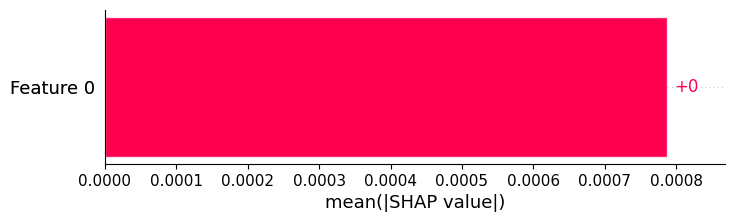

In [ ]:
import shap
import numpy as np

background_data_for_shap = np.array(background_texts.tolist()).reshape(-1, 1)
test_data_for_shap = np.array(test_texts.tolist()).reshape(-1, 1)

explainer = shap.KernelExplainer(
    get_predictions,
    background_data_for_shap
)

shap_values = explainer.shap_values(test_data_for_shap)

shap_exp = shap.Explanation(
    values=shap_values,
    data=test_texts.tolist(),
    feature_names=None
)

shap.plots.bar(shap_exp)